# Baixar o dataset do Kaggle

In [ ]:
!pip install opendatasets
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 10.4 MB/s eta 0:00:00


In [ ]:
#biblioteca
import os
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import opendatasets as od
import cv2
from PIL import Image
import imagehash
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import random
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Definir seed para reprodutibilidade
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [ ]:

od.download("https://www.kaggle.com/datasets/veeralakrishna/200-bird-species-with-11788-images")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Mabylly
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/veeralakrishna/200-bird-species-with-11788-images


100%|██████████| 1.11G/1.11G [00:11<00:00, 101MB/s]


In [ ]:
extract_dir = "./200-bird-species-with-11788-images"

# Extrair CUB_200_2011.tgz
with tarfile.open(os.path.join(extract_dir, "CUB_200_2011.tgz")) as tar:
    tar.extractall(path=extract_dir)

# Extrair segmentations.tgz
with tarfile.open(os.path.join(extract_dir, "segmentations.tgz")) as tar:
    tar.extractall(path=extract_dir)

/tmp/ipython-input-2944794865.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)
/tmp/ipython-input-2944794865.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)



# Criar um Dataframe com os metadados das imagens

In [ ]:
root_dir = './200-bird-species-with-11788-images/CUB_200_2011/images'

In [ ]:
class_counts = {}
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

df_counts = pd.DataFrame(list(class_counts.items()), columns=["Classe", "Num_Imagens"])
df_counts = df_counts.sort_values(by=["Num_Imagens", "Classe"], ascending=[False, True]).reset_index(drop=True)

# Seleciona só as 10 maiores classes
top_classes = df_counts["Classe"].head(10).tolist()
print("Top 10 classes com mais imagens:")
print(df_counts.head(10))

Top 10 classes com mais imagens:
                       Classe  Num_Imagens
0  001.Black_footed_Albatross           60
1        002.Laysan_Albatross           60
2       004.Groove_billed_Ani           60
3    010.Red_winged_Blackbird           60
4         011.Rusty_Blackbird           60
5                013.Bobolink           60
6          014.Indigo_Bunting           60
7          021.Eastern_Towhee           60
8       025.Pelagic_Cormorant           60
9         026.Bronzed_Cowbird           60


In [ ]:
dataframe_list = []
corrupted = []
count_corrupted = 0

In [ ]:
for folder in top_classes:
    child_dir = os.path.join(root_dir, folder)

    for image in os.listdir(child_dir):
        img_dir = os.path.join(child_dir, image)

        try:
            _, image_format = image.split('.')
            image_format = image_format.lower()
        except ValueError:
            image_format = None

        img = cv2.imread(img_dir)

        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)

            # Gerar hash perceptual
            img_hash = imagehash.phash(img_pil)

            width, height, channels = img.shape
            img_corrupted = False
        else:
            count_corrupted += 1
            corrupted.append(img_dir)
            img_corrupted = True
            img_hash, image_format, width, height, channels = None, None, None, None, None

        dataframe_list.append([
            img_dir, img_corrupted, img_hash, image_format,
            width, height, channels, folder
        ])

In [ ]:
print(f'Total de Imagens Corrompidas: {count_corrupted}\nImagens corrompidas {corrupted}')

Total de Imagens Corrompidas: 0
Imagens corrompidas []


In [ ]:
df = pd.DataFrame(columns=['image_path', 'corrupted', 'image_hash', 'image_format', 'width', 'height', 'channels', 'label'], data = dataframe_list)

In [ ]:
df.head()

,image_path,corrupted,image_hash,image_format,width,height,channels,label
0,./200-bird-species-with-11788-images/CUB_200_2...,False,e3cc91326c69b794,jpg,357,500,3,001.Black_footed_Albatross
1,./200-bird-species-with-11788-images/CUB_200_2...,False,f38bcc664b91321b,jpg,390,500,3,001.Black_footed_Albatross
2,./200-bird-species-with-11788-images/CUB_200_2...,False,e6a6199ce919b386,jpg,500,415,3,001.Black_footed_Albatross
3,./200-bird-species-with-11788-images/CUB_200_2...,False,afe0cf9d71339090,jpg,385,500,3,001.Black_footed_Albatross
4,./200-bird-species-with-11788-images/CUB_200_2...,False,bad0c88dbd0ac23f,jpg,359,260,3,001.Black_footed_Albatross


# Verificar a Integridade dos Arquivos

In [ ]:
#Informações estatísticas dos valores de altura, largura e canais das imagens

df.describe().loc[['mean', 'std', 'min', 'max']]

,width,height,channels
mean,385.356667,469.686667,3.0
std,71.129097,61.559872,0.0
min,136.000000,167.000000,3.0
max,500.000000,500.000000,3.0


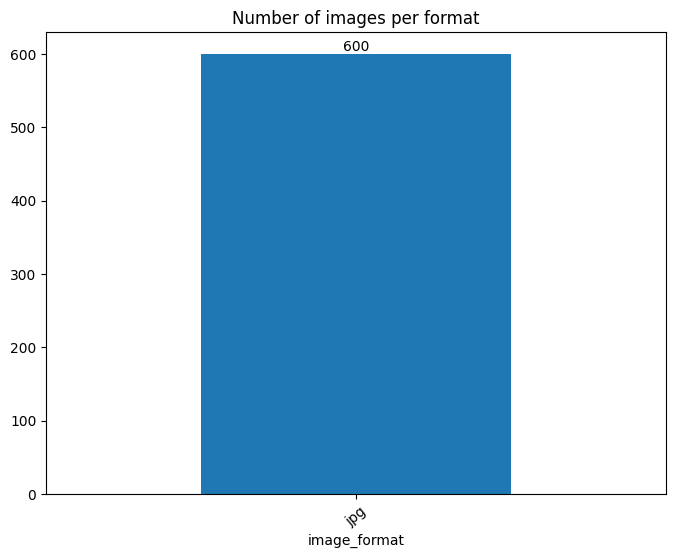

In [ ]:
#Quantidade de Imagens por formato (JPG, PNG, etc.)

# Geração do gráfico de barras
ax = df['image_format'].value_counts().plot(kind='bar', title='Number of images per format', figsize=(8, 6))

# Rotacionando os rótulos no eixo X
plt.xticks(rotation=40)

# Adicionando os valores exatos em cima de cada barra
for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Exibindo o gráfico
plt.show()

# Verificação de consistência com metadados

In [ ]:
# Arquivos de metadados
base_dir = "./200-bird-species-with-11788-images/CUB_200_2011"
images_txt = f"{base_dir}/images.txt"
bbox_txt   = f"{base_dir}/bounding_boxes.txt"
labels_txt = f"{base_dir}/image_class_labels.txt"
split_txt  = f"{base_dir}/train_test_split.txt"

# Carregar metadados
meta_images = pd.read_csv(images_txt, sep=' ', header=None, names=['id', 'caminho'])
meta_bbox   = pd.read_csv(bbox_txt,   sep=' ', header=None, names=['id', 'x', 'y', 'w', 'h'])
meta_labels = pd.read_csv(labels_txt, sep=' ', header=None, names=['id', 'label_id'])
meta_split  = pd.read_csv(split_txt,  sep=' ', header=None, names=['id', 'is_train'])

In [ ]:
meta_images.head()

,id,caminho
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...


In [ ]:
meta_bbox.head()

,id,x,y,w,h
0,1,60.0,27.0,325.0,304.0
1,2,139.0,30.0,153.0,264.0
2,3,14.0,112.0,388.0,186.0
3,4,112.0,90.0,255.0,242.0
4,5,70.0,50.0,134.0,303.0


In [ ]:
meta_labels.head()

,id,label_id
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [ ]:
meta_split.head()

,id,is_train
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [ ]:
# Criar conjunto das imagens do df (classe/arquivo)
imgs_df = {
    f"{row['label']}/{Path(row['image_path']).name}"
    for _, row in df.iterrows()
}

# Subconjunto dos metadados apenas para as imagens do df(10 classes)
meta_imgs_subset = meta_images[meta_images['caminho'].isin(imgs_df)]
ids_df = set(meta_imgs_subset['id'])

In [ ]:
print(ids_df)
len(ids_df)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 52

600

In [ ]:
# Tem Segmentação (images.txt)
imgs_meta = set(meta_imgs_subset['caminho'])
faltando_segmentacao = imgs_df - imgs_meta
print(f"[Segmentação] Total: {len(imgs_df)} | OK: {len(imgs_meta)} | Faltando: {len(faltando_segmentacao)}")


[Segmentação] Total: 600 | OK: 600 | Faltando: 0


In [ ]:
# Bounding Boxes Válida
ids_bbox = set(meta_bbox['id'])
faltando_bbox = ids_df - ids_bbox

# Verificação de inválidas (largura/altura <=0 ou coordenadas negativas)
invalidas = meta_bbox[
    (meta_bbox['w'] <= 0) |
    (meta_bbox['h'] <= 0) |
    (meta_bbox['x'] < 0) |
    (meta_bbox['y'] < 0)
]

print(f"[BBox] Total: {len(ids_df)} | OK: {len(ids_df & ids_bbox)} | "
      f"Faltando: {len(faltando_bbox)} | Inválidas: {len(invalidas)}")

[BBox] Total: 600 | OK: 600 | Faltando: 0 | Inválidas: 0


In [ ]:
# Labels
ids_labels = set(meta_labels['id'])
faltando_labels = ids_df - ids_labels
print(f"[Labels] Total: {len(ids_df)} | OK: {len(ids_df & ids_labels)} | Faltando: {len(faltando_labels)}")


[Labels] Total: 600 | OK: 600 | Faltando: 0


In [ ]:
# Splits
ids_split = set(meta_split['id'])
faltando_split = ids_df - ids_split
print(f"[Split] Total: {len(ids_df)} | OK: {len(ids_df & ids_split)} | Faltando: {len(faltando_split)}")

[Split] Total: 600 | OK: 600 | Faltando: 0


# Analisar a Qualidade das Imagens

In [ ]:
#Total de imagens corrompidas

df['corrupted'].sum()

np.int64(0)

In [ ]:
#Quantidade de imagens corrompidas e não corrompidas

df['corrupted'].value_counts()

,count
corrupted,
False,600


# Verificar a Distribuição das Classes

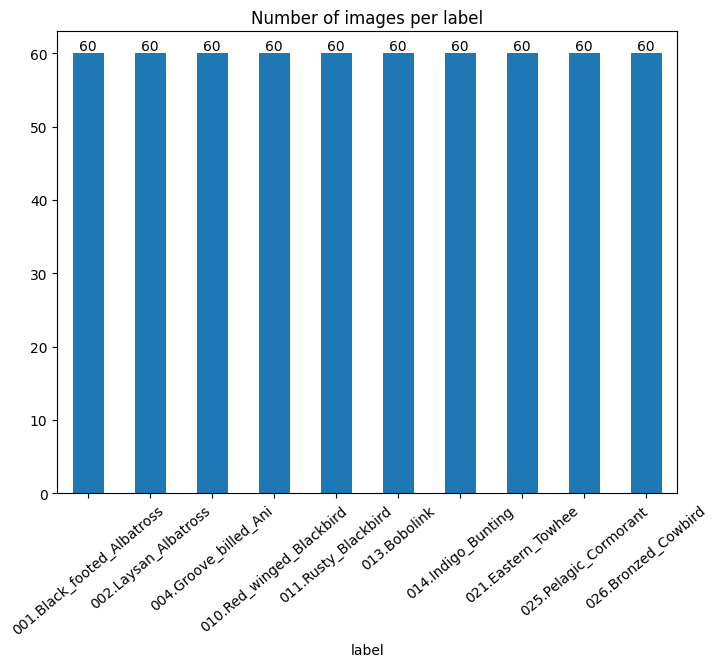

In [ ]:
#Número de Imagens por Classe

ax = df['label'].value_counts().plot(kind='bar', title='Number of images per label', figsize=(8, 6))

# Rotacionando os rótulos no eixo X
plt.xticks(rotation=40)

# Adicionando os valores exatos em cima de cada barra
for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Exibindo o gráfico
plt.show()

# Verificar a Presença de Duplicatas

In [ ]:
#Quantidade de imagens duplicatas

df['image_hash'].duplicated().sum()

np.int64(1)

In [ ]:
#Imagens duplicatas

df_duplicated = df[df['image_hash'].duplicated()]
df_duplicated

,image_path,corrupted,image_hash,image_format,width,height,channels,label
583,./200-bird-species-with-11788-images/CUB_200_2...,False,e34c99d201db8b37,jpg,500,375,3,026.Bronzed_Cowbird


In [ ]:
duplicated_images = {}
for i in range(df_duplicated.shape[0]):
  hash_duplicated = df_duplicated.iloc[i]['image_hash']
  duplicated = df[df['image_hash'] == hash_duplicated]["image_path"].values
  duplicated_images[str(hash_duplicated)] = duplicated.tolist()

In [ ]:
#Imagens correspondentes a cada imagem duplicada

duplicated_images

{'e34c99d201db8b37': ['./200-bird-species-with-11788-images/CUB_200_2011/images/026.Bronzed_Cowbird/Bronzed_Cowbird_0025_796213.jpg',
  './200-bird-species-with-11788-images/CUB_200_2011/images/026.Bronzed_Cowbird/Bronzed_Cowbird_0074_24045.jpg']}

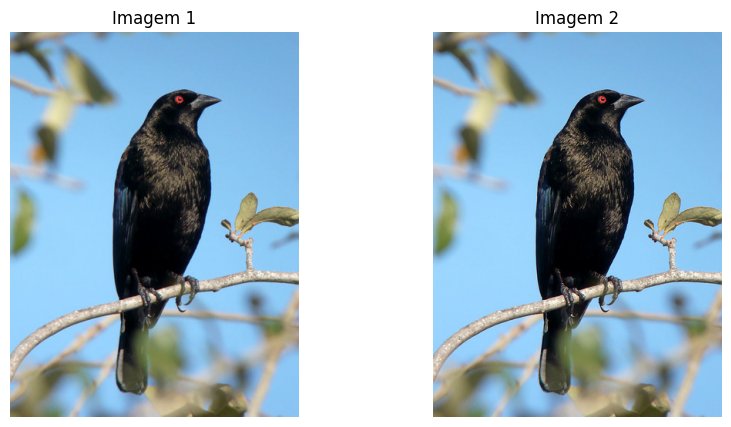

In [ ]:
image1 = cv2.imread('./200-bird-species-with-11788-images/CUB_200_2011/images/026.Bronzed_Cowbird/Bronzed_Cowbird_0025_796213.jpg')
image2 = cv2.imread('./200-bird-species-with-11788-images/CUB_200_2011/images/026.Bronzed_Cowbird/Bronzed_Cowbird_0074_24045.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Converter de BGR (formato OpenCV) para RGB (formato Matplotlib)
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Mostrar a primeira imagem
axes[0].imshow(image1_rgb)
axes[0].axis('off')  # Remove os eixos
axes[0].set_title('Imagem 1')

# Mostrar a segunda imagem
axes[1].imshow(image2_rgb)
axes[1].axis('off')  # Remove os eixos
axes[1].set_title('Imagem 2')

# Exibir as imagens
plt.show()

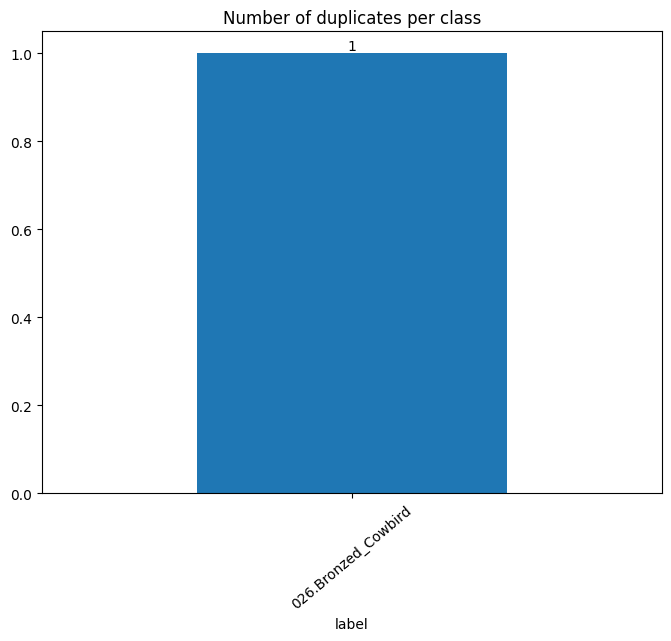

In [ ]:
# Agrupando duplicatas por classe (coluna 'label') e contando
duplicates_by_class = df_duplicated.groupby('label').size()

# Gerando o gráfico de barras
ax = duplicates_by_class.plot(kind='bar', title='Number of duplicates per class', figsize=(8, 6))

# Adicionando os valores exatos em cima de cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Ajustando a rotação dos rótulos no eixo X
plt.xticks(rotation=40)

# Exibindo o gráfico
plt.show()

In [ ]:
removed = 0
removed_paths = []

# percorre cada hash duplicado
for hash_value, paths in duplicated_images.items():
    if len(paths) > 1:
        # mantém apenas a primeira imagem, remove o resto
        for duplicate_path in paths[1:]:
            if os.path.exists(duplicate_path):
                os.remove(duplicate_path)
                removed += 1
                removed_paths.append(duplicate_path)
                print(f"Removido: {duplicate_path}")

print(f"\nTotal de imagens duplicadas removidas: {removed}")

Removido: ./200-bird-species-with-11788-images/CUB_200_2011/images/026.Bronzed_Cowbird/Bronzed_Cowbird_0074_24045.jpg

Total de imagens duplicadas removidas: 1


In [ ]:
# Atualiza o DataFrame, removendo as imagens apagadas
df = df[~df['image_path'].isin(removed_paths)].reset_index(drop=True)
print(f"Número de imagens restantes no DataFrame: {len(df)}")

Número de imagens restantes no DataFrame: 599


Gerando as mascaras das 10 classes

In [ ]:
def gerar_mascaras_10_classes_melhorado(df, base_path='./200-bird-species-with-11788-images'):
    seg_root = os.path.join(base_path, "segmentations")
    output_root = "./Masked_Images_10"
    os.makedirs(output_root, exist_ok=True)

    print(f"Diretório de máscaras de entrada: {seg_root}")
    print(f"Diretório de imagens de saída: {output_root}\n")

    classes = df['label'].unique()

    for cls in classes:
        found_count, not_found_count = 0, 0
        df_class = df[df['label'] == cls]
        out_dir = os.path.join(output_root, cls)
        os.makedirs(out_dir, exist_ok=True)

        for idx, row in df_class.iterrows():
            jpg_path = row['image_path']
            jpg_filename = os.path.basename(jpg_path)
            base_name = os.path.splitext(jpg_filename)[0]
            seg_path = os.path.join(seg_root, cls, base_name + ".png")

            if not os.path.exists(seg_path):
                not_found_count += 1
                continue

            found_count += 1
            try:
                image = Image.open(jpg_path).convert("RGB")
                # Usando NEAREST para redimensionar a máscara e preservar bordas nítidas
                mask = Image.open(seg_path).convert("L").resize(image.size, Image.NEAREST)
                mask_array = np.expand_dims(np.array(mask) / 255.0, axis=-1)
                masked_array = np.uint8(np.array(image) * mask_array)
                Image.fromarray(masked_array).save(os.path.join(out_dir, jpg_filename))
            except Exception as e:
                print(f"Erro ao processar o arquivo {jpg_filename}: {e}")
                continue

        print(f"Classe '{cls}' concluída. Máscaras encontradas: {found_count}, Não encontradas: {not_found_count}")

# Executar a função para criar o novo dataset mascarado
print("Iniciando a geração de imagens mascaradas...")
gerar_mascaras_10_classes_melhorado(df)
print("\nDataset de imagens mascaradas foi criado com sucesso em './Masked_Images_10'")

Iniciando a geração de imagens mascaradas...
Diretório de máscaras de entrada: ./200-bird-species-with-11788-images/segmentations
Diretório de imagens de saída: ./Masked_Images_10

Classe '001.Black_footed_Albatross' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '002.Laysan_Albatross' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '004.Groove_billed_Ani' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '010.Red_winged_Blackbird' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '011.Rusty_Blackbird' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '013.Bobolink' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '014.Indigo_Bunting' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '021.Eastern_Towhee' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '025.Pelagic_Cormorant' concluída. Máscaras encontradas: 60, Não encontradas: 0
Classe '026.Bronzed_Cowbird' concluída. Máscar

Preparando dados


In [ ]:
DATA_DIR = './Masked_Images_10'

masked_paths = []
labels = []
for cls in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            masked_paths.append(os.path.join(class_path, img_name))
            labels.append(cls)

df_masked = pd.DataFrame({'image_path': masked_paths, 'label': labels})

print(f"\nTotal de imagens mascaradas encontradas: {len(df_masked)}")

# Dividir os dados em treino, validação e teste
train_val_df, test_df = train_test_split(
    df_masked,
    test_size=0.2,
    random_state=SEED,
    stratify=df_masked['label']
)
train_df, validation_df = train_test_split(
    train_val_df,
    test_size=0.25,
    random_state=SEED,
    stratify=train_val_df['label']
)

print(f"Tamanho do conjunto de Treino: {len(train_df)}")
print(f"Tamanho do conjunto de Validação: {len(validation_df)}")
print(f"Tamanho do conjunto de Teste: {len(test_df)}")

# Configuração dos Geradores de Imagem

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


validation_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='image_path', y_col='label',
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical',
    seed=SEED
)
validation_generator = validation_test_datagen.flow_from_dataframe(
    dataframe=validation_df, x_col='image_path', y_col='label',
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=False, seed=SEED
)
test_generator = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='image_path', y_col='label',
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=False, seed=SEED
)



Total de imagens mascaradas encontradas: 599
Tamanho do conjunto de Treino: 359
Tamanho do conjunto de Validação: 120
Tamanho do conjunto de Teste: 120
Found 359 validated image filenames belonging to 10 classes.
Found 120 validated image filenames belonging to 10 classes.
Found 120 validated image filenames belonging to 10 classes.


Construção do modelo

In [ ]:
base_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Adicionar o cabeçalho de classificação personalizado
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)

predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo para a primeira fase de treinamento
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)  # Era 0.1

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=loss_fn,
    metrics=['accuracy']
)
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3451         │ (None, 111, 111,  │        864 │ input_layer_17[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_3451[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3451     │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3452         │ (None, 109, 109,  │      9,216 │ activation_3451[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_3452[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3452     │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3453         │ (None, 109, 109,  │     18,432 │ activation_3452[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_3453[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3453     │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_68    │ (None, 54, 54,    │          0 │ activation_3453[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3454         │ (None, 54, 54,    │      5,120 │ max_pooling2d_68… │
│ (Conv2D)            │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3454[0][0] │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3454     │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3455         │ (None, 52, 52,    │    138,240 │ activation_3454[… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_3455[0][0] │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3455     │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 56,043,114 (213.79 MB)

 Trainable params: 1,706,378 (6.51 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)  # Era 4
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

Treinamento do modelo


--- INICIANDO FASE 1 ---
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.1611 - loss: 2.6946 - val_accuracy: 0.4333 - val_loss: 1.7327 - learning_rate: 5.0000e-04
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.3673 - loss: 1.8587 - val_accuracy: 0.5417 - val_loss: 1.4992 - learning_rate: 5.0000e-04
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.4562 - loss: 1.6419 - val_accuracy: 0.5583 - val_loss: 1.4058 - learning_rate: 5.0000e-04
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.4962 - loss: 1.5035 - val_accuracy: 0.6083 - val_loss: 1.2955 - learning_rate: 5.0000e-04
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.5463 - loss: 1.4952 - val_accuracy: 0.6417 - val_loss: 1.2594 - learning_rate: 5.0000e-04
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5992 - loss: 1.3062 - val_accuracy: 0.6250 - val_loss: 1.2388 - learning_rate: 5.0000e-04
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.6

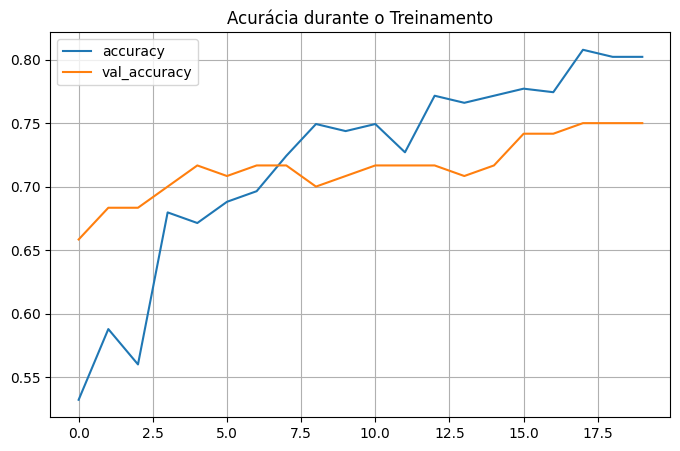

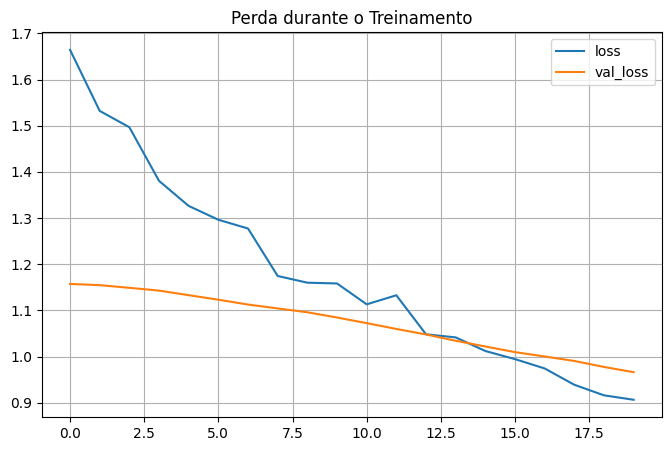

In [ ]:

# --- FASE 1: Treinamento do Cabeçalho ---
print("\n--- INICIANDO FASE 1 ---")
EPOCHS_PHASE1 = 10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS_PHASE1,
    callbacks=[learning_rate_reduction, early_stop, checkpoint]
)

print("\n--- INICIANDO FASE 2 ---")
base_model.trainable = True

# Descongela só as últimas 30% das camadas
fine_tune_at = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer = Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

EPOCHS_PHASE2 = 20
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[learning_rate_reduction, early_stop, checkpoint]
)

# --- VISUALIZAÇÃO ---
pd.DataFrame(history_fine_tune.history)[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.title("Acurácia durante o Treinamento")
plt.grid(True)
plt.show()

pd.DataFrame(history_fine_tune.history)[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.title("Perda durante o Treinamento")
plt.grid(True)
plt.show()



Avaliação do modelo

In [ ]:
best_model = keras.models.load_model('best_model.keras')
results = best_model.evaluate(test_generator)
print(f"Melhor modelo — perda: {results[0]:.4f}, acurácia: {results[1]*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.7823 - loss: 0.8479
Melhor modelo — perda: 0.8518, acurácia: 77.50%


In [ ]:
# Obter previsões
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Relatório de métricas
print("Relatório de classificação:\n")
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
Relatório de classificação:

                            precision    recall  f1-score   support

001.Black_footed_Albatross       0.88      0.58      0.70        12
      002.Laysan_Albatross       0.69      0.92      0.79        12
     004.Groove_billed_Ani       0.67      0.83      0.74        12
  010.Red_winged_Blackbird       1.00      1.00      1.00        12
       011.Rusty_Blackbird       0.58      0.58      0.58        12
              013.Bobolink       0.46      0.50      0.48        12
        014.Indigo_Bunting       0.92      1.00      0.96        12
        021.Eastern_Towhee       1.00      0.83      0.91        12
     025.Pelagic_Cormorant       0.92      0.92      0.92        12
       026.Bronzed_Cowbird       0.78      0.58      0.67        12

                  accuracy                           0.78       120
                 macro avg       0.79      0.78      0.77       120
              weighted avg       0.79      0.78 

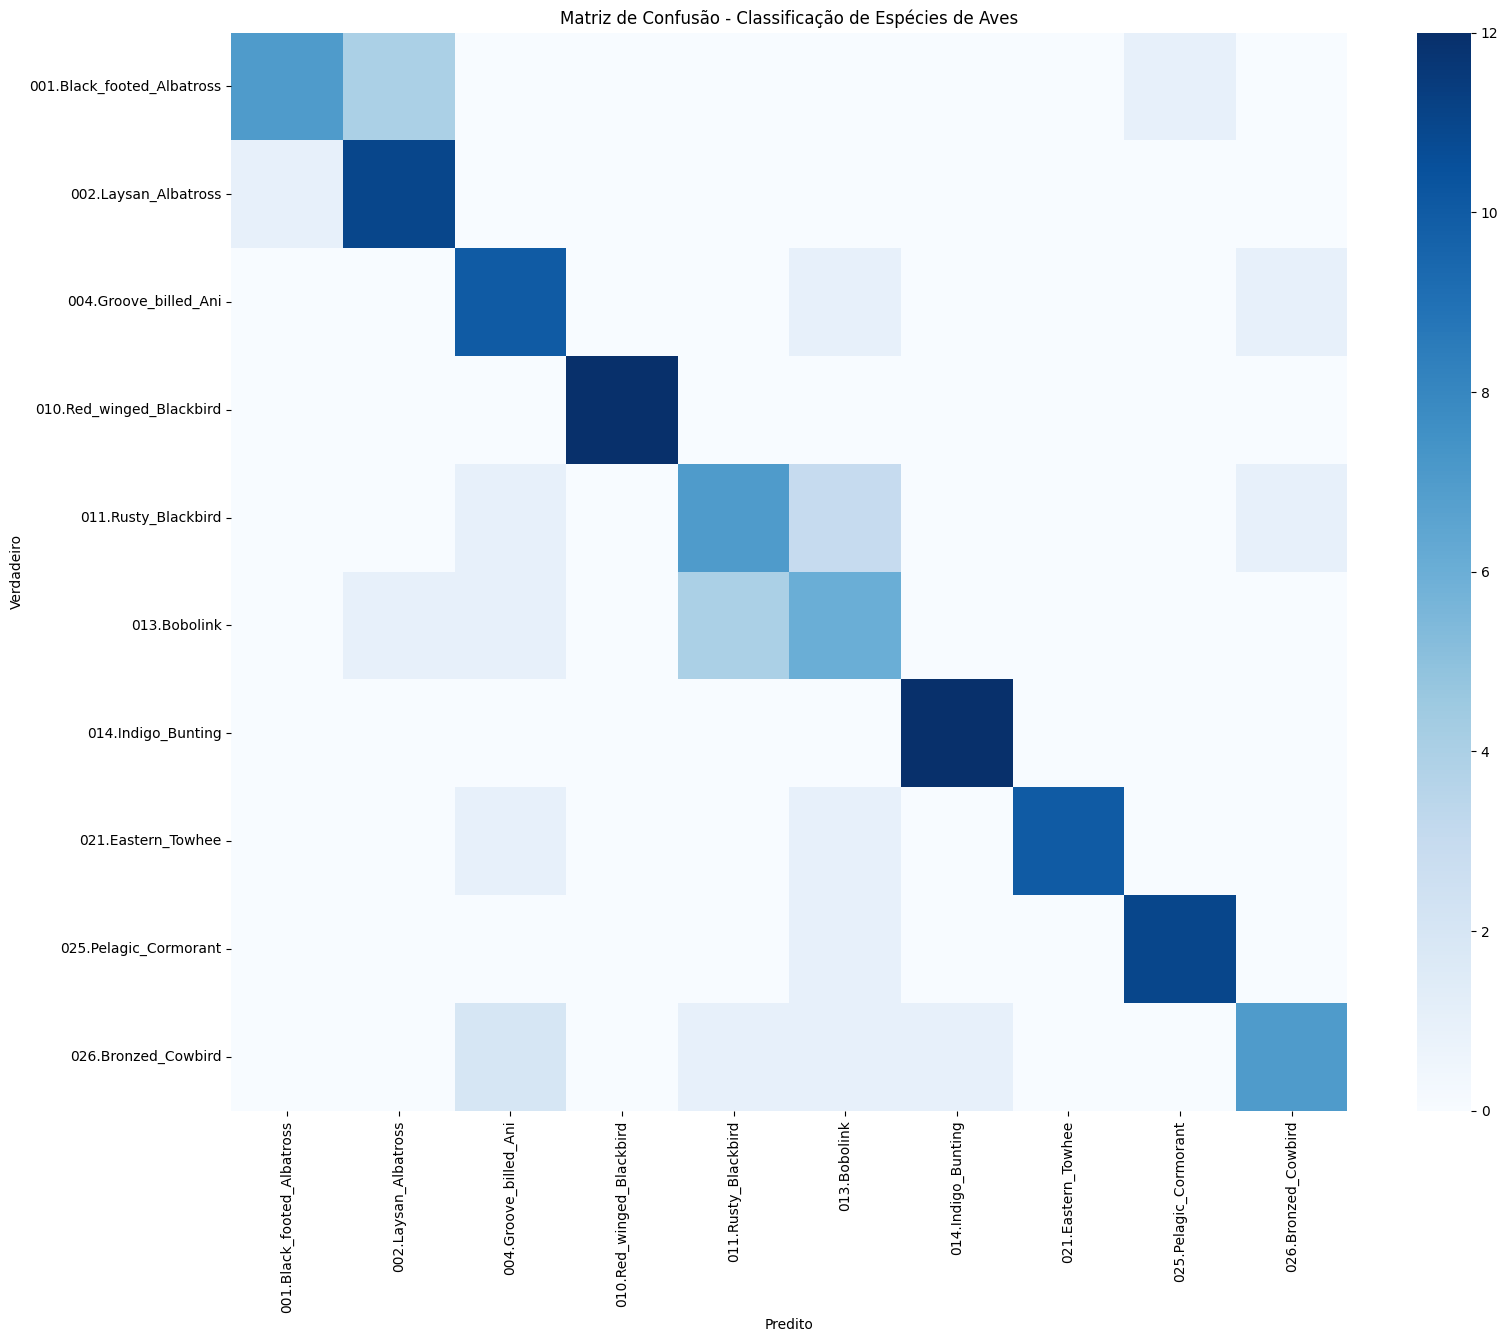

In [ ]:
# Matriz de confusão
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(18, 14))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Matriz de Confusão - Classificação de Espécies de Aves")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step


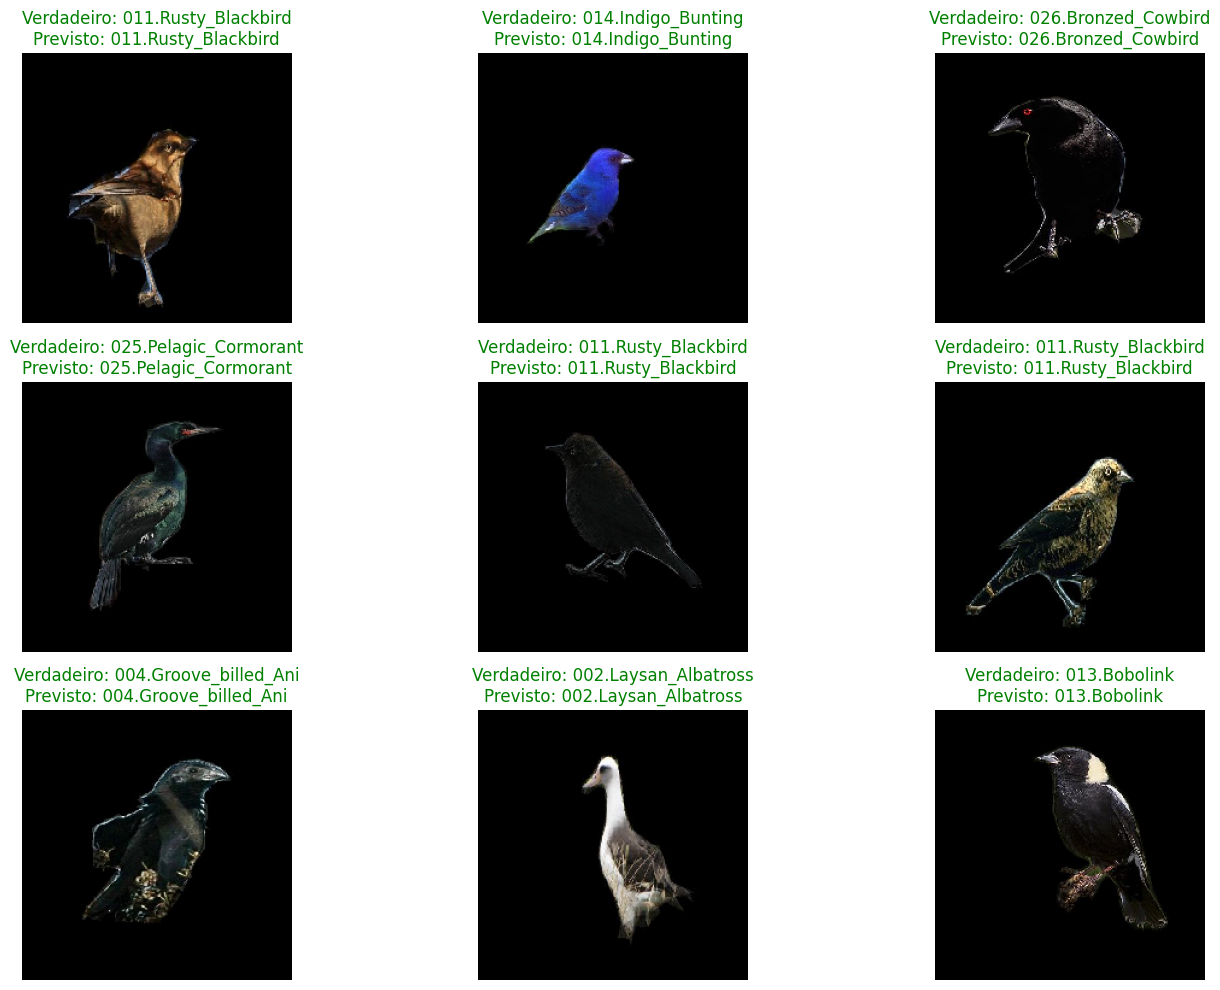

In [ ]:
# Grid com imagens
test_generator.reset()
x_test, y_true = next(test_generator)
y_pred_batch = np.argmax(best_model.predict(x_test), axis=1)
labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_test[i])
    true_label = labels[np.argmax(y_true[i])]
    pred_label = labels[y_pred_batch[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Verdadeiro: {true_label}\nPrevisto: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()